[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/1h_pytorch_apis.ipynb)
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://www.kaggle.com/notebooks/welcome?src=https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/1h_pytorch_apis.ipynb)
[![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/1h_pytorch_apis.ipynb)
[![SageMaker](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/1h_pytorch_apis.ipynb)

# APIs en PyTorch

Curso: [Aprendizaje Profundo](http://turing.iimas.unam.mx/~gibranfp/cursos/aprendizaje_profundo/). Profesor: [Gibran Fuentes Pineda](http://turing.iimas.unam.mx/~gibranfp/). Ayudantes: [Bere](https://turing.iimas.unam.mx/~bereml/) y [Ricardo](https://turing.iimas.unam.mx/~ricardoml/).

---
---

En esta libreta veremos de manera breve las interfaces de programación de aplicaciones ([API](https://es.wikipedia.org/wiki/Interfaz_de_programaci%C3%B3n_de_aplicaciones)s) para la definición de arquitecturas que provee PyTorch.

## 1 Preparación

### 1.1 Bibliotecas

In [1]:
import math
# sistema de archivos
import os
# números aleatorios
import random

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

### 1.2 Auxiliares

In [2]:
# datos
URL = 'https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2023-1/data/califs/califs.csv'
data_dir = '../data'
filepath = os.path.join(data_dir, 'califs.csv')

def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

## 2 Datos

Descargamos los datos.

In [3]:
! mkdir {data_dir}
! wget -nc {URL} -O {filepath}

mkdir: cannot create directory ‘../data’: File exists
--2022-09-05 22:56:57--  https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2023-1/data/califs/califs.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 666 [text/plain]
Saving to: ‘../data/califs.csv’

../data/califs.csv  100%[===================>]     666  --.-KB/s    in 0s      

2022-09-05 22:56:57 (11.3 MB/s) - ‘../data/califs.csv’ saved [666/666]



Cargamos los datos.

In [4]:
df = pd.read_csv(filepath)
df.head(5)

,prev,horas,calif
0,5.6,8.2,5.1
1,6.7,9.3,5.9
2,5.1,10.0,5.4
3,5.7,10.4,6.5
4,7.1,10.4,6.7


Graficamos los datos para tener una idea más clara de como se encuentran distribuidos.

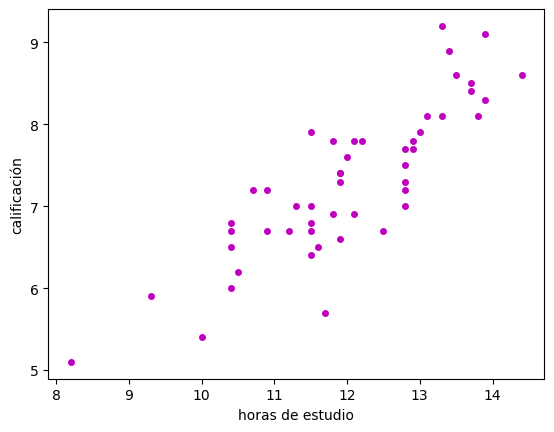

In [5]:
# se obtiene el atributo de entrada y se agrega una dimensión
x_trn = np.array(df.iloc[:,1], dtype='float32')[..., np.newaxis]
# se obtiene la salda
y_trn = np.array(df.iloc[:,-1], dtype='float32')[..., np.newaxis]
# graficamos
plt.plot(x_trn, y_trn, '.', color='m', markersize=8)
plt.xlabel('horas de estudio')
plt.ylabel('calificación')
plt.show()

In [6]:
x_trn = np.array(df.iloc[:,:2], dtype="float32")
y_trn = np.array(df.iloc[:,-1], dtype="float32")[..., np.newaxis]

x_trn = torch.tensor(x_trn)
y_trn = torch.tensor(y_trn)

print(x_trn.shape)
print(y_trn.shape)

torch.Size([50, 2])
torch.Size([50, 1])


### 2.1 Conjunto de datos

Para hacer lotes podemos user las clase [`TensorDataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset).

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/29227f0ad9d952a2239a592a80a7990a085f43d7/figs/califs_tuberia.svg" width="1050"/>

In [7]:
ds = TensorDataset(x_trn, y_trn)
ds[0]

(tensor([5.6000, 8.2000]), tensor([5.1000]))

### 2.2 Cargador de datos


Para ver el funcionamiento de la tubería de datos imprimimos la forma de cada lote y su primer elemento.

In [8]:
def build_dl(batch_size=16, shuffle=True):
    return DataLoader(ds, batch_size=batch_size, shuffle=True)

# creamos un DataLoader
dl = build_dl()

x, y = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([16, 2]) dtype=torch.float32
y shape=torch.Size([16, 1]) dtype=torch.float32


In [9]:
len(ds)

50

## 3 Ciclo de entrenamiento

<img src="https://raw.githubusercontent.com/bereml/iap/master/fig/supervisado.svg" width="700"/>

In [10]:
# optimizador
def train(model, dl, epochs=5):

    opt = optim.SGD(model.parameters(), lr=1e-3)

    # historial de pérdida
    loss_hist = []

    # ciclo de entrenamiento
    for epoch in range(epochs):

        # historial
        loss_hist = []
        
        # entrenamiento de una época
        for x, y_true in dl:
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # calculamos de pérdida
            loss = F.mse_loss(y_lgts, y_true)
            # vaciamos los gradientes
            opt.zero_grad()
            # retropropagamos
            loss.backward()
            # actulizamos parámetros
            opt.step()

            # guardamos historial de pérdida
            loss_hist.append(loss.item() * 100)
            
        # imprimimos la pérdida de la época
        loss = np.mean(loss_hist)
        print(f'E{epoch:02} loss=[{loss:6.2f}]')

        
def train_model(build_model, epochs=5):
    set_seed()
    dl = build_dl()
    model = build_model()
    train(model, dl, epochs)

## 4 Definición de la arquitectura

Para implementar arquitecturas, PyTorch define dos clases fundamentales.

* `nn.Module` define una red neuronal que internamente puede tener otras redes neuronales anidadas (o capas). Tres metodos importantes son:
  * `__init__(self, args)` es el inicilizador que define al objeto,
  * `fordward(x)` realizar predicción (hacia adelante),
  * `parameters(x)` regresa una lista de los parámetros (`nn.Parameter`) de la red y redes anidadas.


* `nn.Parameter` envuelve un tensor solo para marcarlo como parámetro y que sea regresado por `nn.Module.parameters(x)`.

### 4.1 Alto nivel (similar a Keras)

En esta API basta con apilar las capas (del paquete [`torch.nn`](https://pytorch.org/docs/stable/nn.html)) usando la clase [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential).

In [11]:
def build_high():
    model = nn.Sequential(
        nn.Linear(2, 2),
        nn.ReLU(),
        nn.Linear(2, 1),
    )
    return model

build_high()

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=1, bias=True)
)

### 4.2 Medio nivel (Chainer, tensorflow.keras.model)

En esta API heredamos de [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module), creamos las capas en el inicializador e implementamos la inferencia en el método `fordward`. 

In [12]:
#se define la clase RegLin que hereda de torch.nn.Module
class LinRegMed(nn.Module):

    #se define el inicializador
    def __init__(self):
        # se llama al inicializador de la clase padre
        super().__init__()
        # importante: se definen las capas como atributos de la clase
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 1)

    # método para inferencia
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

def build_med():
    return LinRegMed()

build_med()

LinRegMed(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
)

### 4.3 Bajo nivel

En esta interfaz debemos implementar las capaz partiendo de los parámetros.

In [13]:
class MyLinear(nn.Module):

    def __init__(self, in_features, out_features, init):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.init = init
        # se envuelven los tensores en parámetros (clase)
        # para que model.parameters() los regrese
        # y sean visibles al optimizador
        self.weight = nn.Parameter(torch.zeros(out_features, in_features))
        self.bias = nn.Parameter(torch.zeros(out_features))
        if init == 'he':
            self.reset_parameters()

    def reset_parameters(self):
        # Delving Deep into Rectifiers: 
        #   Surpassing Human-Level Performance on ImageNet Classification
        # https://arxiv.org/abs/1502.01852
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)
        
    def forward(self, x):
        # X * W + B
        return F.linear(x, self.weight, self.bias)
    
    def extra_repr(self):
        return 'in_features={}, out_features={}, init={}, bias={}'.format(
            self.in_features, self.out_features, self.init, self.bias is not None
        )


class LinRegLow(nn.Module):

    def __init__(self, init='zeros'):
        super().__init__()
        
        self.cls = nn.Sequential(
            MyLinear(2, 2, init),
            nn.ReLU(),
            MyLinear(2, 1, init),
        )

    def forward(self, x):
        return self.cls(x)

In [14]:
def build_low_he():
    return LinRegLow(init='he')

build_low_he()

LinRegLow(
  (cls): Sequential(
    (0): MyLinear(in_features=2, out_features=2, init=he, bias=True)
    (1): ReLU()
    (2): MyLinear(in_features=2, out_features=1, init=he, bias=True)
  )
)

In [15]:
def build_low_zeros():
    return LinRegLow(init='zeros')

build_low_zeros()

LinRegLow(
  (cls): Sequential(
    (0): MyLinear(in_features=2, out_features=2, init=zeros, bias=True)
    (1): ReLU()
    (2): MyLinear(in_features=2, out_features=1, init=zeros, bias=True)
  )
)

## 5 Entrenando modelos

In [16]:
train_model(build_high)

E00 loss=[5240.13]
E01 loss=[2730.91]
E02 loss=[622.67]
E03 loss=[ 47.03]
E04 loss=[ 16.73]


In [17]:
train_model(build_med)

E00 loss=[5240.13]
E01 loss=[2730.91]
E02 loss=[622.67]
E03 loss=[ 47.03]
E04 loss=[ 16.73]


In [18]:
train_model(build_low_he)

E00 loss=[5240.13]
E01 loss=[2730.91]
E02 loss=[622.67]
E03 loss=[ 47.03]
E04 loss=[ 16.73]


In [19]:
train_model(build_low_zeros, epochs=50)

E00 loss=[5586.75]
E01 loss=[5281.79]
E02 loss=[5079.85]
E03 loss=[4928.56]
E04 loss=[4967.41]
E05 loss=[5092.14]
E06 loss=[4979.04]
E07 loss=[4874.94]
E08 loss=[4741.26]
E09 loss=[4634.36]
E10 loss=[4300.48]
E11 loss=[4150.66]
E12 loss=[4242.56]
E13 loss=[4827.45]
E14 loss=[4070.02]
E15 loss=[4345.31]
E16 loss=[4081.96]
E17 loss=[4353.34]
E18 loss=[3907.37]
E19 loss=[4045.78]
E20 loss=[3561.13]
E21 loss=[3714.62]
E22 loss=[3872.94]
E23 loss=[3616.32]
E24 loss=[3596.34]
E25 loss=[3809.44]
E26 loss=[3482.73]
E27 loss=[3434.74]
E28 loss=[3262.29]
E29 loss=[3426.96]
E30 loss=[3523.23]
E31 loss=[3233.74]
E32 loss=[3154.37]
E33 loss=[2906.46]
E34 loss=[3174.32]
E35 loss=[3401.14]
E36 loss=[3237.41]
E37 loss=[2964.21]
E38 loss=[2828.31]
E39 loss=[3274.97]
E40 loss=[2859.65]
E41 loss=[2756.75]
E42 loss=[2838.57]
E43 loss=[2767.52]
E44 loss=[2539.08]
E45 loss=[2510.41]
E46 loss=[2434.60]
E47 loss=[2533.85]
E48 loss=[2765.56]
E49 loss=[2469.54]


## 6 Obteniendo  parámetros

In [20]:
high = build_high()
med = build_med()

In [21]:
list(high.parameters())

[Parameter containing:
 tensor([[ 0.0297,  0.4558],
         [-0.5345, -0.4854]], requires_grad=True),
 Parameter containing:
 tensor([-0.4106,  0.4949], requires_grad=True),
 Parameter containing:
 tensor([[-0.2542,  0.5964]], requires_grad=True),
 Parameter containing:
 tensor([0.2557], requires_grad=True)]

In [22]:
list(med.parameters())

[Parameter containing:
 tensor([[ 0.0895, -0.0053],
         [-0.1398,  0.0887]], requires_grad=True),
 Parameter containing:
 tensor([-0.1615, -0.0050], requires_grad=True),
 Parameter containing:
 tensor([[ 0.0902, -0.5531]], requires_grad=True),
 Parameter containing:
 tensor([-0.3706], requires_grad=True)]

In [23]:
list(high.named_parameters())

[('0.weight',
  Parameter containing:
  tensor([[ 0.0297,  0.4558],
          [-0.5345, -0.4854]], requires_grad=True)),
 ('0.bias',
  Parameter containing:
  tensor([-0.4106,  0.4949], requires_grad=True)),
 ('2.weight',
  Parameter containing:
  tensor([[-0.2542,  0.5964]], requires_grad=True)),
 ('2.bias',
  Parameter containing:
  tensor([0.2557], requires_grad=True))]

In [24]:
list(med.named_parameters())

[('fc1.weight',
  Parameter containing:
  tensor([[ 0.0895, -0.0053],
          [-0.1398,  0.0887]], requires_grad=True)),
 ('fc1.bias',
  Parameter containing:
  tensor([-0.1615, -0.0050], requires_grad=True)),
 ('fc2.weight',
  Parameter containing:
  tensor([[ 0.0902, -0.5531]], requires_grad=True)),
 ('fc2.bias',
  Parameter containing:
  tensor([-0.3706], requires_grad=True))]